In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#------------------------| normal |--------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

#---------------------| processsing |------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
import math

#------------------------| model |---------------------------
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

#---------| hyperparameter & feature selecting |----------
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.inspection import permutation_importance
#---------------------| evaluation |-------------------------
from xgboost import plot_importance
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

In [ ]:
def rfe(model, x_train, y_train):
  rfecv = RFECV(estimator = model, step = 1, cv = 5, scoring='accuracy').fit(x_train, y_train)
  print("Optimal number of features : %d" % rfecv.n_features_)
  print("Support is %s" % rfecv.support_)
  print("Ranking of features : %s" % rfecv.ranking_)

  return rfecv.n_features_, rfecv.support_

In [ ]:
def Randomized_gridsearch(model, param_grid_, x_train, y_train_):
  optimal_params = RandomizedSearchCV(
      model,
      param_grid_,
      cv = 5,
      scoring = 'accuracy',
      verbose = 1,
      n_jobs = -1,
    )

  optimal_params.fit(x_train, y_train_)
  print(optimal_params.best_params_)
  return optimal_params.best_params_

In [ ]:
def ROC_and_AUC(label, score, name):
    fpr, tpr , _ = roc_curve(label, score)
    roc_auc = auc(fpr, tpr)
    name = name + '_auc = ' + str(roc_auc.round(3))
    lw = 2
    plt.plot(fpr, tpr, lw = lw, label = name)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc = "lower right")

In [ ]:
def model_evaluation_result(X_train_Std, y_train, X_test_Std, y_test, model, roctrainname, roctestname):
    
    model.fit(X_train_Std, y_train)
    
    train_pred = model.predict(X_train_Std)
    score_train = model.decision_function(X_train_Std)
    train_acc = accuracy_score(y_train, train_pred)
    tn, fp, fn, tp = confusion_matrix(y_train, train_pred).ravel()
    train_specificity = tn / (tn+fp)
    train_sensitivity = tp / (tp+fn)
    train_PPV = tp / (tp+fp)
    train_NPV = tn / (fn+tn)
    train_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ROC_and_AUC(y_train, score_train, roctrainname)

    test_pred = model.predict(X_test_Std)
    score_test = model.decision_function(X_test_Std)
    test_acc = accuracy_score(y_test, test_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
    test_specificity = tn / (tn+fp)
    test_sensitivity = tp / (tp+fn)
    test_PPV = tp / (tp+fp)
    test_NPV = tn / (fn+tn)
    test_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ROC_and_AUC(y_test, score_test, roctestname)
    result = [{'Accuracy': train_acc,'Specificity': train_specificity, 'Sensitivity': train_sensitivity, 'MCC': train_MCC, 'PPV': train_PPV, 'NPV': train_NPV},
          {'Accuracy': test_acc,'Specificity': test_specificity, 'Sensitivity': test_sensitivity, 'MCC': test_MCC, 'PPV': test_PPV, 'NPV': test_NPV}]
    result_df = pd.DataFrame(result)
    result_df.index = ['Training set', 'Test_set']
    result_df = result_df.round(3)
    print(result_df)
    return result_df, score_train, train_pred, score_test, test_pred, model

In [ ]:
def confusion_matrix_scorer(clf, X, y):
  y_pred = clf.predict(X)
  cm = confusion_matrix(y, y_pred)
  return {'tn': cm[0, 0], 'fp': cm[0, 1],'fn': cm[1, 0], 'tp': cm[1, 1]}

In [ ]:
def proba_model_evaluation_result(X_train_Std, y_train, X_test_Std, y_test, model, roctrainname, roctestname):
    
    model.fit(X_train_Std, y_train)
    
    train_pred = model.predict(X_train_Std)
    score_train = model.predict_proba(X_train_Std)
    train_acc = accuracy_score(y_train, train_pred)
    tn, fp, fn, tp = confusion_matrix(y_train, train_pred).ravel()
    train_specificity = tn / (tn+fp)
    train_sensitivity = tp / (tp+fn)
    train_PPV = tp / (tp+fp)
    train_NPV = tn / (fn+tn)
    train_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ROC_and_AUC(y_train, score_train[:, 1], roctrainname)

    test_pred = model.predict(X_test_Std)
    score_test = model.predict_proba(X_test_Std)
    test_acc = accuracy_score(y_test, test_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
    test_specificity = tn / (tn+fp)
    test_sensitivity = tp / (tp+fn)
    test_PPV = tp / (tp+fp)
    test_NPV = tn / (fn+tn)
    test_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ROC_and_AUC(y_test, score_test[:, 1], roctestname)
    result = [{'Accuracy': train_acc,'Specificity': train_specificity, 'Sensitivity': train_sensitivity, 'MCC': train_MCC, 'PPV': train_PPV, 'NPV': train_NPV},
          {'Accuracy': test_acc,'Specificity': test_specificity, 'Sensitivity': test_sensitivity, 'MCC': test_MCC, 'PPV': test_PPV, 'NPV': test_NPV}]
    result_df = pd.DataFrame(result)
    result_df.index = ['Training set', 'Test_set']
    result_df = result_df.round(3)
    print(result_df)
    return result_df, score_train, train_pred, score_test, test_pred, model

In [ ]:
def pointer(model, x_train, y_train):
  cv_results = cross_validate(model, x_train, y_train, cv = 5, scoring = confusion_matrix_scorer)
  tn = round(cv_results['test_tn'].mean())
  fp = round(cv_results['test_fp'].mean())
  fn = round(cv_results['test_fn'].mean())
  tp = round(cv_results['test_tp'].mean())
  accuracy = (tp+tn)/(tn+fp+fn+tp)
  precision = tp/(tp+fp)
  sensitivity = tp/(tp+fn)
  specificity = tn/(tn+fp)
  MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
  print("TN_result: ", cv_results['test_tn'], " TN_mean: ", round(cv_results['test_tn'].mean()))
  print("FP_result: ",cv_results['test_fp']," FP_result: ", round(cv_results['test_fp'].mean()))
  print("FN_result: ",cv_results['test_fn']," FN_result: ", round(cv_results['test_fn'].mean()))
  print("TP_result: ",cv_results['test_tp']," TP_result: ", round(cv_results['test_tp'].mean()))
  print('accuracy:', accuracy)
  print('precision:', precision)
  print('sensitivity:', sensitivity)
  print('specificity:', specificity)
  print('MCC:', MCC)

In [ ]:
def confusion_matrix_(actual, predict):
  sns.set()
  f,ax = plt.subplots()
  cm = confusion_matrix(actual, predict)
  sns.heatmap(cm, annot=True, ax = ax)

  ax.set_title('confusion matrix') 
  ax.set_xlabel('predict') 
  ax.set_ylabel('true') 

In [ ]:
def std(x_train):
  Std = preprocessing.StandardScaler().fit(x_train)
  x_train_Std = Std.transform(x_train)

  return x_train_Std

## **preprocessing**

**data_split**

In [ ]:
rd = pd.read_csv("/content/drive/MyDrive/BinaryClassifier_2weeks_data_v2.csv")

In [ ]:
from collections import Counter
label_count = Counter(rd["label"])
print("label count:", label_count)

label count: Counter({0: 5178, 1: 1889})


In [ ]:
x = rd.iloc[:, 0:-1]
y = rd.iloc[:, -1]

sss = StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=0)
for train_index, test_index in sss.split(x, y):
  print("TRAIN:", train_index, "TEST:", test_index)
  x_train, x_test = x.iloc[train_index,:], x.iloc[test_index,:]
  y_train, y_test = y[train_index], y[test_index]

TRAIN: [2426 3567 2003 ... 4767 4405 2960] TEST: [1833 3223 6953 ... 7003 3553 2313]


In [ ]:
c_idx = []
d_idx = []
idx = 0
for i in rd.columns:
  if(i[0] == 'd'): d_idx.append(idx)
  elif(i[0] == 'c'): c_idx.append(idx)
  idx += 1

In [ ]:
d = x_train.iloc[:, d_idx]
c = x_train.iloc[:, c_idx]

**statistic**

In [ ]:
d_s = pd.concat([d, y_train], axis = 1)
d_prefeature = []
p_value = []
d_s = d_s[d_s['label'] >= 0]
columns = list(d_s.columns)
for i in columns:
    table = pd.crosstab(d_s['label'], d_s[i])
    chi2, p, dof, expected = chi2_contingency(table)
    p_value.append(p)
    if p < 0.05:
      d_prefeature.append(i)

d_p_value = pd.DataFrame([columns, p_value]).T
d_p_value = d_p_value.rename(columns = {0:'features', 1:'p_value'})
print(d_p_value)
print(d_prefeature[0:-1])

   features   p_value
0        d1   0.20515
1        d2  0.002174
2        d3       0.0
3        d4  0.001579
4        d5  0.003363
5        d6  0.000003
6        d7       0.0
7        d8       0.0
8        d9       0.0
9       d10       1.0
10      d11       0.0
11      d12  0.004547
12      d13       1.0
13      d14  0.000024
14      d15  0.000024
15      d16       1.0
16      d17   0.69424
17      d18  0.693631
18      d19  0.443395
19      d20  0.000058
20      d21  0.000087
21      d22       0.0
22      d23  0.000032
23      d24  0.143004
24      d25       1.0
25      d26  0.503152
26      d27   0.11922
27      d28       0.0
28      d29       0.0
29      d30       0.0
30      d31       0.0
31      d32       0.0
32      d33  0.000535
33      d34  0.008406
34      d35  0.352993
35      d36  0.438117
36      d37   0.00001
37      d38  0.331573
38      d39   0.11922
39     d499  0.115664
40     d500       0.0
41    label       0.0
['d2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd11'

In [ ]:
c_s = pd.concat([c, y_train], axis = 1)

c_s = c_s[c_s['label'] >= 0]
columns = list(c_s.columns)
c_prefeature = []
p_value = []
for i in columns:
    value1=[]
    value0=[]
    my_col = c_s[[i,'label']]
    for j in range(0, my_col.shape[0]):
        if (str(my_col.iloc[j,1]) == '1'):
            value1.append(my_col.iloc[j,0])
        elif (str(my_col.iloc[j,1]) == '-1'):
            continue
        else:
            value0.append(my_col.iloc[j,0])
    result = mannwhitneyu(value0, value1, alternative= 'two-sided') 
    p_value.append(result[1])
    
    if result[1] < 0.05:
      c_prefeature.append(i)

c_p_value = pd.DataFrame([columns, p_value]).T
c_p_value = c_p_value.rename(columns = {0:'features', 1:'p_value'})
print(c_p_value)
print(c_prefeature[0:-1])

    features   p_value
0        c40   0.99965
1        c41  0.011837
2        c42  0.462073
3        c43  0.019354
4        c44  0.403169
..       ...       ...
471     c513  0.045233
472     c514   0.74955
473     c515  0.499261
474     c516  0.930279
475    label       0.0

[476 rows x 2 columns]
['c41', 'c43', 'c45', 'c46', 'c47', 'c49', 'c50', 'c51', 'c53', 'c54', 'c55', 'c56', 'c57', 'c58', 'c59', 'c60', 'c61', 'c62', 'c64', 'c65', 'c66', 'c67', 'c69', 'c70', 'c71', 'c72', 'c73', 'c74', 'c75', 'c78', 'c80', 'c82', 'c83', 'c84', 'c88', 'c89', 'c90', 'c92', 'c94', 'c96', 'c98', 'c100', 'c101', 'c102', 'c104', 'c105', 'c106', 'c107', 'c108', 'c110', 'c111', 'c112', 'c113', 'c115', 'c116', 'c117', 'c118', 'c121', 'c122', 'c123', 'c124', 'c125', 'c126', 'c129', 'c131', 'c133', 'c134', 'c135', 'c139', 'c140', 'c141', 'c143', 'c145', 'c147', 'c148', 'c149', 'c151', 'c152', 'c153', 'c155', 'c156', 'c157', 'c158', 'c159', 'c161', 'c162', 'c163', 'c164', 'c166', 'c167', 'c168', 'c169', 'c17

In [ ]:
prefeature = d_prefeature[0:-1] + c_prefeature[0:-1]
x_pretrain = x_train.loc[:, prefeature]
x_pretest = x_test.loc[:, prefeature]
y_train = y_train
y_test = y_test

In [ ]:
x_pretrain_std = std(x_pretrain)
x_pretest_std = std(x_pretest)

In [ ]:
x_pretrain_std = pd.DataFrame(x_pretrain_std)
x_pretest_std = pd.DataFrame(x_pretest_std)

x_pretrain_std.columns = prefeature
x_pretrain_std.index = train_index
x_pretest_std.columns = prefeature
x_pretest_std.index = test_index

# **Modeling**

# **svc**

only_statistic

In [ ]:
param_grid = {
        'kernel': ["rbf"],
        'C': [256, 128, 64, 32, 16, 8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125],
        'gamma': [256, 128, 64, 32, 16, 8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125]
        }

model = SVC()
best_para = Randomized_gridsearch(model, param_grid, x_pretrain_std, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'kernel': 'rbf', 'gamma': 0.015625, 'C': 16}


              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     0.992        0.995        0.983  0.978  0.986  0.994
Test_set         0.860        0.918        0.700  0.635  0.758  0.894


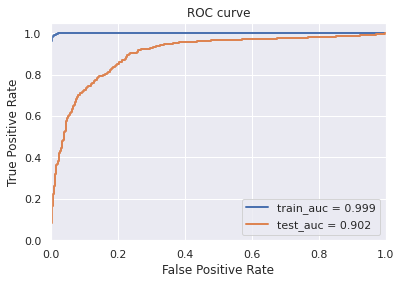



TN_result:  [658 663 651 662 655]  TN_mean:  658
FP_result:  [67 62 74 63 69]  FP_result:  67
FN_result:  [87 75 81 64 77]  FN_result:  77
TP_result:  [178 189 183 200 188]  TP_result:  188
accuracy: 0.8545454545454545
precision: 0.7372549019607844
sensitivity: 0.7094339622641509
specificity: 0.9075862068965517
MCC: 0.6247086810062852




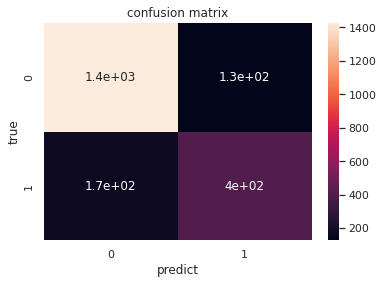

In [ ]:
svc_model = SVC(**best_para)
svc_model.fit(x_pretrain_std, y_train)
plt.figure()
df_svc, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = model_evaluation_result(x_pretrain_std, y_train, x_pretest_std, y_test, svc_model, 'train', 'test')
plt.show()

print("\n")
pointer(svc_model, x_pretrain_std, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

with feature_selection

In [ ]:
permut_model = SVC(kernel = "rbf").fit(x_pretrain_std, y_train)

perm = permutation_importance(permut_model, x_pretrain_std, y_train, n_repeats = 5, scoring = "accuracy", random_state=0)

In [ ]:
important_features=[]
for i in perm.importances_mean.argsort()[::-1]:
  if perm.importances_mean[i] != 0:
    important_features.append(x_pretrain_std.columns[i])

print("n_feature: ", len(important_features))
print(important_features)

n_feature:  166
['c501', 'c263', 'c234', 'c285', 'c284', 'c98', 'c223', 'c148', 'c277', 'c124', 'd23', 'd9', 'c429', 'd500', 'c252', 'c386', 'c43', 'c225', 'c145', 'c282', 'c354', 'c258', 'c325', 'c438', 'c434', 'c175', 'd33', 'c58', 'c392', 'c59', 'c279', 'c201', 'c253', 'c140', 'c73', 'c89', 'c503', 'c405', 'c206', 'c294', 'c365', 'c74', 'c117', 'd37', 'c47', 'c513', 'c360', 'c157', 'c254', 'c106', 'c55', 'd12', 'c207', 'c45', 'c121', 'c151', 'c100', 'c49', 'c116', 'c443', 'c203', 'c507', 'c231', 'c186', 'c110', 'c505', 'c60', 'c185', 'c176', 'c65', 'd20', 'c381', 'd3', 'c115', 'c133', 'c274', 'd15', 'd14', 'c149', 'c184', 'c158', 'c78', 'c70', 'c172', 'c82', 'c72', 'd29', 'c46', 'c83', 'c167', 'c173', 'c180', 'd32', 'c141', 'c129', 'd30', 'c71', 'c67', 'c64', 'c191', 'c135', 'c125', 'c174', 'd4', 'c502', 'c56', 'c131', 'c147', 'c90', 'c80', 'c134', 'd11', 'c182', 'c192', 'c163', 'c168', 'c111', 'c118', 'c161', 'c123', 'c122', 'd8', 'c112', 'd31', 'c84', 'c61', 'd21', 'c75', 'c102', 

In [ ]:
svc_train = x_pretrain_std.loc[:, important_features]
svc_test = x_pretest_std.loc[:, important_features]

In [ ]:
param_grid = {
        'kernel': ["rbf"],
        'C': [256, 128, 64, 32, 16, 8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125],
        'gamma': [256, 128, 64, 32, 16, 8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125]
        }

model = SVC()
best_para = Randomized_gridsearch(model, param_grid, svc_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'kernel': 'rbf', 'gamma': 0.125, 'C': 2}


              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     0.997        0.998        0.992  0.991  0.995  0.997
Test_set         0.820        0.959        0.439  0.498  0.798  0.824


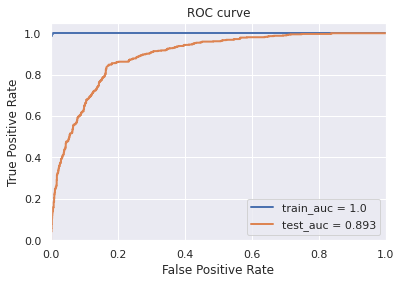



TN_result:  [700 699 690 690 691]  TN_mean:  694
FP_result:  [25 26 35 35 33]  FP_result:  31
FN_result:  [160 152 162 134 151]  FN_result:  152
TP_result:  [105 112 102 130 114]  TP_result:  113
accuracy: 0.8151515151515152
precision: 0.7847222222222222
sensitivity: 0.42641509433962266
specificity: 0.9572413793103448
MCC: 0.48180138420044727




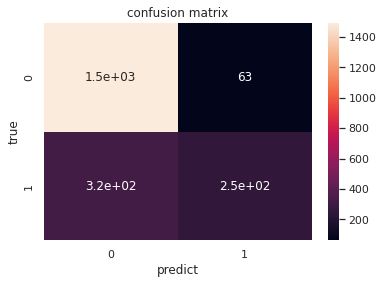

In [ ]:
svc_model = SVC(**best_para)
svc_model.fit(svc_train, y_train)
plt.figure()
df_svc, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = model_evaluation_result(svc_train, y_train, svc_test, y_test, svc_model, 'train', 'test')
plt.show()

print("\n")
pointer(svc_model, svc_train, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

# KNN

only statistic

[0.14799726282031644, 0.17084433822553147, 0.17529511495133332, 0.18964590291182815, 0.19025298485359143, 0.1965201049933103, 0.19227502527805862, 0.19894496021897434, 0.19813749221231536, 0.20339451134193287, 0.20339491987621405, 0.2126962241219067, 0.21370673366628878, 0.2159309985599167, 0.21957063047052938, 0.22462419952814305, 0.22381734432290545, 0.22361409851804193, 0.2256371602782119, 0.22644483255201164]
[0.14799726282031644, 0.14799726282031644, 0.1702401160237359, 0.16457701381867218, 0.17832439664593347, 0.17306778605059692, 0.17872986691995796, 0.17670741796120948, 0.18257049769688793, 0.18115349654277857, 0.18843357743256628, 0.19409381989766206, 0.19389322956562594, 0.1973302284727968, 0.20117126778400796, 0.20400200181797756, 0.2040011847494152, 0.20521412303009878, 0.20420402201999777, 0.20804526559834957]


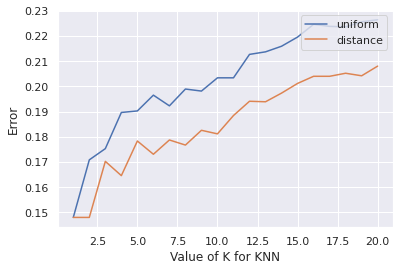

u_k:  1
d_k:  1


In [ ]:
k_range = range(1, 21)
uni_k_error = []
dis_k_error = []

ubest_k = 0
ubest_error = 1
dbest_k = 0
dbest_error = 1
for method in ["uniform", "distance"]:
  for k in k_range:
      knn = KNeighborsClassifier(n_neighbors=k, weights = method)
      scores = cross_val_score(knn, x_pretrain_std, y_train, cv=5, scoring='accuracy')

      if(method == 'uniform'):
         uni_k_error.append(1 - scores.mean())
         if ( (1 - scores.mean()) < ubest_error):
           ubest_k = k
           ubest_error = 1 - scores.mean()
      else:
         dis_k_error.append(1 - scores.mean())
         if ( (1 - scores.mean()) < dbest_error):
           dbest_k = k
           dbest_error = 1 - scores.mean()

print(uni_k_error)
print(dis_k_error)
plt.plot()
unifrom, = plt.plot(k_range, uni_k_error, label = 'uniform')
distance, = plt.plot(k_range, dis_k_error, label = 'distance')
plt.xlabel('Value of K for KNN')
plt.ylabel('Error')
plt.legend(handles = [unifrom, distance], loc='upper right')
plt.show()

print("u_k: ", ubest_k)
print("d_k: ", dbest_k)

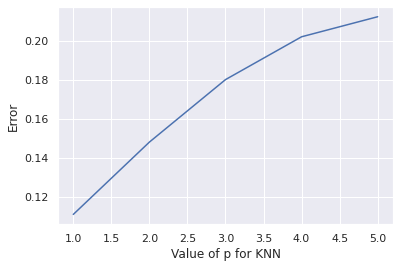

In [ ]:
p_range = range(1, 6)
p_error = []

for p in p_range:
    knn = KNeighborsClassifier(n_neighbors= 1, weights = 'distance', p = p)
    
    scores = cross_val_score(knn, x_pretrain_std, y_train, cv=5, scoring='accuracy')
    p_error.append(1 - scores.mean())


plt.plot(p_range, p_error)
plt.xlabel('Value of p for KNN')
plt.ylabel('Error')
plt.show()

              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     1.000        1.000        1.000  1.000  1.000  1.000
Test_set         0.901        0.928        0.825  0.748  0.807  0.936


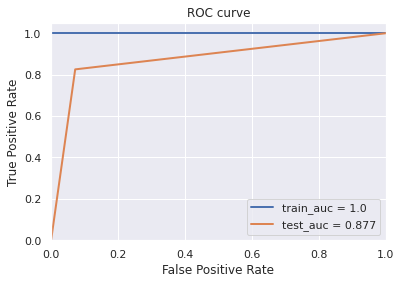



TN_result:  [670 663 671 676 662]  TN_mean:  668
FP_result:  [55 62 54 49 62]  FP_result:  56
FN_result:  [67 50 55 46 48]  FN_result:  53
TP_result:  [198 214 209 218 217]  TP_result:  211
accuracy: 0.8896761133603239
precision: 0.7902621722846442
sensitivity: 0.7992424242424242
specificity: 0.9226519337016574
MCC: 0.7193191642776955




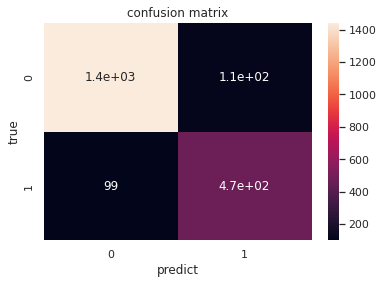

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors= 1, weights = 'distance', p = 1)
plt.figure()
df_knn, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(x_pretrain_std, y_train, x_pretest_std, y_test, knn_model, 'train', 'test')
plt.show()

print("\n")
pointer(knn_model, x_pretrain_std, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

with feature selection

In [ ]:
permut_model = KNeighborsClassifier().fit(x_pretrain_std, y_train)

perm = permutation_importance(permut_model, x_pretrain_std, y_train, n_repeats = 5, scoring = "accuracy", random_state=0)

In [ ]:
important_features=[]
for i in perm.importances_mean.argsort()[::-1]:
  if perm.importances_mean[i] != 0:
    important_features.append(x_pretrain_std.columns[i])

print("n_feature: ", len(important_features))
print(important_features)

n_feature:  136
['c148', 'c98', 'c501', 'c225', 'c274', 'd500', 'c223', 'c263', 'c282', 'c503', 'c47', 'c277', 'c108', 'c279', 'c502', 'c57', 'c149', 'c96', 'c174', 'c121', 'd12', 'c231', 'd3', 'c177', 'c159', 'c58', 'c43', 'c126', 'c147', 'c64', 'c75', 'c115', 'c254', 'c94', 'c70', 'c113', 'c172', 'c185', 'c123', 'c206', 'c325', 'c161', 'c285', 'c175', 'c284', 'c72', 'c124', 'c234', 'c168', 'c88', 'c163', 'c41', 'c139', 'c61', 'c92', 'c73', 'c129', 'c167', 'c134', 'c117', 'c186', 'c258', 'c78', 'c89', 'c143', 'c190', 'c180', 'c158', 'c80', 'c83', 'c365', 'c112', 'c135', 'c184', 'c133', 'c252', 'c140', 'c82', 'd7', 'd29', 'd8', 'c107', 'c111', 'c166', 'c131', 'c182', 'c62', 'c173', 'c162', 'd31', 'c110', 'c84', 'd2', 'c141', 'c176', 'c153', 'c294', 'c443', 'c434', 'c203', 'c192', 'c46', 'c164', 'c90', 'c116', 'c65', 'c381', 'c169', 'c145', 'd37', 'c59', 'c45', 'c67', 'd4', 'c66', 'c51', 'c438', 'c429', 'd33', 'c386', 'c60', 'c513', 'c125', 'c74', 'c191', 'c122', 'd9', 'c392', 'c71', 'c

In [ ]:
knn_train = x_pretrain_std.loc[:, important_features]
knn_test = x_pretest_std.loc[:, important_features]

[0.14961444577218086, 0.17145121590015422, 0.17590137982453447, 0.18883802637088787, 0.19126472000081696, 0.19490312630858642, 0.19328594335672178, 0.19773222620543152, 0.19611545178784806, 0.20056459437652552, 0.2035971443453748, 0.2120897549815648, 0.2135053262656903, 0.21269642838904723, 0.21775101878236358, 0.21977244640540905, 0.22219954856961932, 0.22361491558660407, 0.2242215889940865, 0.22786122090469918]
[0.14961444577218086, 0.14961444577218086, 0.16983587135255485, 0.16477985108925441, 0.17872945838567666, 0.1720570722390743, 0.1781236020467567, 0.17549427541338558, 0.18156060095392745, 0.1817615998202451, 0.1896467199803904, 0.1944990859045459, 0.1949041476442892, 0.19470192317512836, 0.20117126778400796, 0.2011710635168673, 0.20359673581109372, 0.20299087947217376, 0.20218239012981176, 0.20743981779371057]


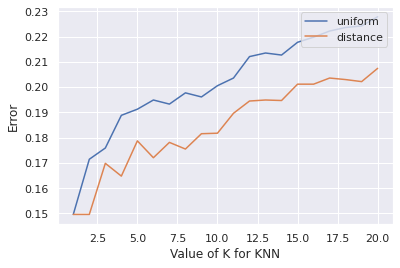

u_k:  1
d_k:  1


In [ ]:
k_range = range(1, 21)
uni_k_error = []
dis_k_error = []

ubest_k = 0
ubest_error = 1
dbest_k = 0
dbest_error = 1
for method in ["uniform", "distance"]:
  for k in k_range:
      knn = KNeighborsClassifier(n_neighbors=k, weights = method)
      scores = cross_val_score(knn, knn_train, y_train, cv=5, scoring='accuracy')

      if(method == 'uniform'):
         uni_k_error.append(1 - scores.mean())
         if ( (1 - scores.mean()) < ubest_error):
           ubest_k = k
           ubest_error = 1 - scores.mean()
      else:
         dis_k_error.append(1 - scores.mean())
         if ( (1 - scores.mean()) < dbest_error):
           dbest_k = k
           dbest_error = 1 - scores.mean()

print(uni_k_error)
print(dis_k_error)
plt.plot()
unifrom, = plt.plot(k_range, uni_k_error, label = 'uniform')
distance, = plt.plot(k_range, dis_k_error, label = 'distance')
plt.xlabel('Value of K for KNN')
plt.ylabel('Error')
plt.legend(handles = [unifrom, distance], loc='upper right')
plt.show()

print("u_k: ", ubest_k)
print("d_k: ", dbest_k)

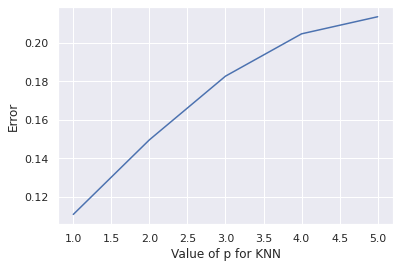

In [ ]:
p_range = range(1, 6)
p_error = []

for p in p_range:
    knn = KNeighborsClassifier(n_neighbors= 1, weights = 'distance', p = p)
    
    scores = cross_val_score(knn, knn_train, y_train, cv=5, scoring='accuracy')
    p_error.append(1 - scores.mean())


plt.plot(p_range, p_error)
plt.xlabel('Value of p for KNN')
plt.ylabel('Error')
plt.show()

              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     1.000        1.000        1.000  1.000  1.000  1.000
Test_set         0.901        0.931        0.818  0.747  0.811  0.934


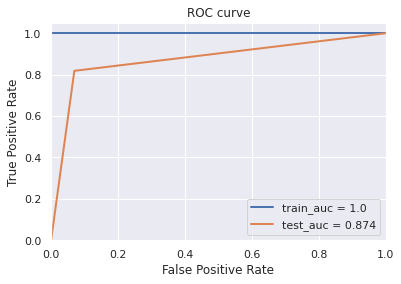



TN_result:  [670 663 671 676 662]  TN_mean:  668
FP_result:  [55 62 54 49 62]  FP_result:  56
FN_result:  [67 50 55 46 48]  FN_result:  53
TP_result:  [198 214 209 218 217]  TP_result:  211
accuracy: 0.8896761133603239
precision: 0.7902621722846442
sensitivity: 0.7992424242424242
specificity: 0.9226519337016574
MCC: 0.7193191642776955




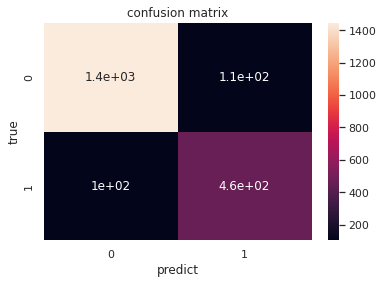

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors= 1, weights = 'distance', p = 1)
plt.figure()
df_knn, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(knn_train, y_train, knn_test, y_test, knn_model, 'train', 'test')
plt.show()

print("\n")
pointer(knn_model, x_pretrain_std, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

# XGBoost

only statistic

In [ ]:
param_grid = {
    'n_estimators':[100, 200, 300, 400],
    'max_depth': [20, 30, 40, 50, 60],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'gamma': [0.1, 1, 10]
}

model = XGBClassifier()
best_para = Randomized_gridsearch(model, param_grid, x_pretrain_std, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.3, 'gamma': 0.1}


              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     1.000        1.000        1.000  1.000  1.000  1.000
Test_set         0.927        0.956        0.848  0.813  0.876  0.945


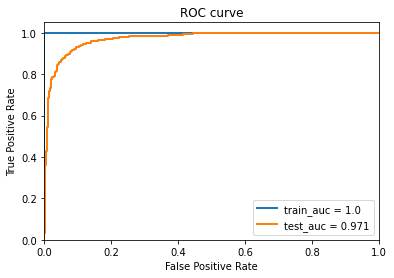



TN_result:  [685 690 685 692 693]  TN_mean:  689
FP_result:  [40 35 40 33 31]  FP_result:  36
FN_result:  [42 45 39 28 37]  FN_result:  38
TP_result:  [223 219 225 236 228]  TP_result:  226
accuracy: 0.9251769464105156
precision: 0.8625954198473282
sensitivity: 0.8560606060606061
specificity: 0.9503448275862069
MCC: 0.8083632495739865




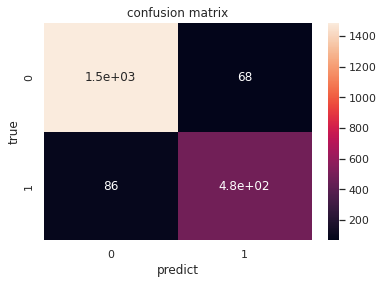

In [ ]:
xgb_model = XGBClassifier(**best_para)
xgb_model.fit(x_pretrain_std, y_train)
plt.figure()
df_xgb, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(x_pretrain_std, y_train, x_pretest_std, y_test, xgb_model, 'train', 'test')
plt.show()

print("\n")
pointer(xgb_model, x_pretrain_std, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

with feature selection

In [ ]:
xgb = XGBClassifier()
n_feature, selected = rfe(xgb, x_pretrain_std, y_train)

Optimal number of features : 77
Support is [False  True False False False  True False False False False  True False
 False False  True False False False False  True False False  True False
 False  True False False False False False False False False False  True
 False  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True False  True  True False  True False  True False
 False False  True  True False  True False False False False False  True
  True  True  True  True  True  True  True  True False  True False False
 False  True  True  True False False False False False False False  True
  True False  True  True  True False False False False False False  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False  True False False  True False
 False False False  True  True  True False False False False False  True
  True  True False  True False  True False False False False  True  True
 False  

In [ ]:
selected = ['d3', 'd7', 'd14', 'd22', 'd31', 'd34', 'c41', 'c55', 'c57', 'c58', 'c59', 'c60', 'c61', 'c62', 'c64', 'c66', 'c67', 'c69', 'c70', 'c71','c72', 'c73', 'c75', 'c78', 'c82', 'c84', 'c92', 'c94', 'c98', 'c106', 'c107', 'c108', 'c110', 'c111', 'c112', 'c113', 'c115', 'c116', 'c118','c124', 'c125', 'c126', 'c141', 'c143', 'c147', 'c148', 'c149', 'c158','c161', 'c162', 'c163', 'c164', 'c166', 'c167', 'c168', 'c169', 'c172','c173', 'c174', 'c175', 'c176', 'c186', 'c192', 'c223', 'c225', 'c231','c263', 'c274', 'c277', 'c282', 'c285', 'c365', 'c381', 'c392', 'c501','c502', 'c505']


In [ ]:
xgb_train = x_pretrain_std.loc[:, selected]
xgb_test = x_pretest_std.loc[:, selected]

print(xgb_train.columns)

Index(['d3', 'd7', 'd14', 'd22', 'd31', 'd34', 'c41', 'c55', 'c57', 'c58',
       'c59', 'c60', 'c61', 'c62', 'c64', 'c66', 'c67', 'c69', 'c70', 'c71',
       'c72', 'c73', 'c75', 'c78', 'c82', 'c84', 'c92', 'c94', 'c98', 'c106',
       'c107', 'c108', 'c110', 'c111', 'c112', 'c113', 'c115', 'c116', 'c118',
       'c124', 'c125', 'c126', 'c141', 'c143', 'c147', 'c148', 'c149', 'c158',
       'c161', 'c162', 'c163', 'c164', 'c166', 'c167', 'c168', 'c169', 'c172',
       'c173', 'c174', 'c175', 'c176', 'c186', 'c192', 'c223', 'c225', 'c231',
       'c263', 'c274', 'c277', 'c282', 'c285', 'c365', 'c381', 'c392', 'c501',
       'c502', 'c505'],
      dtype='object')


In [ ]:
param_grid = {
    'n_estimators':[200, 300, 400, 500, 550],
    'max_depth': [5, 10, 20, 30, 40],
    'learning_rate': [0.0001, 0.005, 0.01, 0.1, 0.2, 0.3, 0.4],
    'gamma': [0.001, 0.05, 0.1, 1, 10]
}

model = XGBClassifier()
best_para = Randomized_gridsearch(model, param_grid, xgb_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 400, 'max_depth': 20, 'learning_rate': 0.2, 'gamma': 0.001}


In [ ]:
param_grid = {
    'n_estimators':[400],
    'max_depth': [20],
    'learning_rate': [0.2],
    'gamma': [0.0001, 0.0005, 0.0008, 0.001, 0.05,]
}

model = XGBClassifier()
best_para = Randomized_gridsearch(model, param_grid, xgb_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'n_estimators': 400, 'max_depth': 20, 'learning_rate': 0.2, 'gamma': 0.001}


              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     1.000        1.000        1.000  1.000  1.000  1.000
Test_set         0.941        0.964        0.877  0.847  0.899  0.955


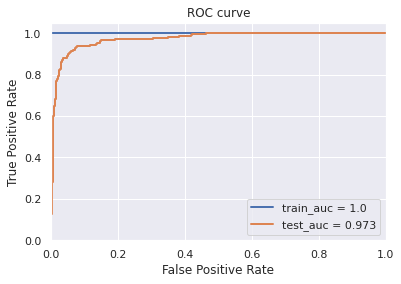



TN_result:  [697 692 689 694 698]  TN_mean:  694
FP_result:  [28 33 36 31 26]  FP_result:  31
FN_result:  [32 38 35 33 42]  FN_result:  36
TP_result:  [233 226 229 231 223]  TP_result:  228
accuracy: 0.9322548028311426
precision: 0.8803088803088803
sensitivity: 0.8636363636363636
specificity: 0.9572413793103448
MCC: 0.8259202895231342




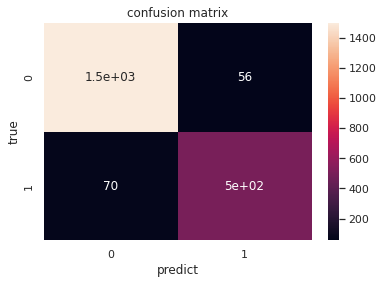

In [ ]:
xgb_model = XGBClassifier(**best_para)
xgb_model.fit(xgb_train, y_train)
plt.figure()
df_xgb, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(xgb_train, y_train, xgb_test, y_test, xgb_model, 'train', 'test')
plt.show()

print("\n")
pointer(xgb_model, xgb_train, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

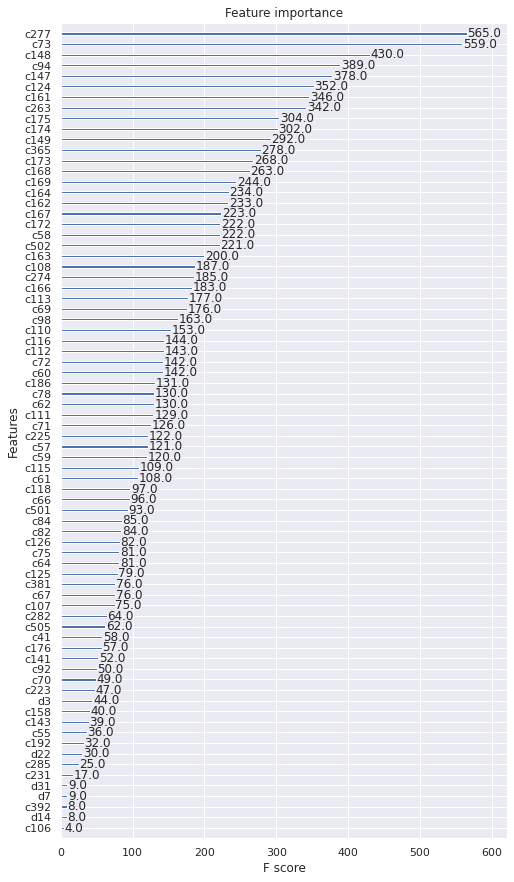

In [ ]:
xgb_model = XGBClassifier(**best_para)
xgb_model.fit(xgb_train, y_train)

fig, ax = plt.subplots(1,1,figsize=(8, 15))
plot_importance(xgb_model, ax = ax)
plt.show()

# RandomForest

only statistic

In [ ]:
param_grid = {
    'max_depth': [40, 50, 60, 70],
    'criterion': ['entropy', 'gini'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [250, 300, 350, 400]
}

model = RandomForestClassifier()
best_para = Randomized_gridsearch(model, param_grid, x_pretrain_std, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50, 'criterion': 'gini'}


              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     1.000        1.000        1.000  1.000  1.000  1.000
Test_set         0.909        0.955        0.781  0.761  0.864  0.923


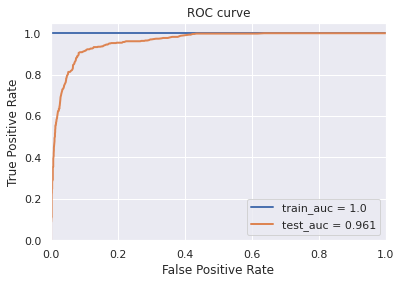



TN_result:  [673 690 682 690 686]  TN_mean:  684
FP_result:  [52 35 43 35 38]  FP_result:  41
FN_result:  [65 48 56 50 64]  FN_result:  57
TP_result:  [200 216 208 214 201]  TP_result:  208
accuracy: 0.901010101010101
precision: 0.8353413654618473
sensitivity: 0.7849056603773585
specificity: 0.9434482758620689
MCC: 0.7432341123584031




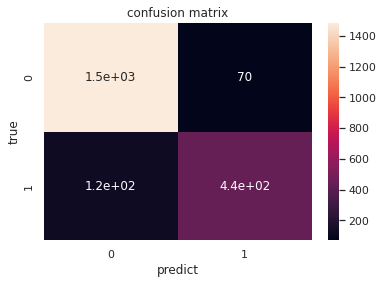

In [ ]:
rf_model = RandomForestClassifier(**best_para)
rf_model.fit(x_pretrain_std, y_train)
plt.figure()
df_rf, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(x_pretrain_std, y_train, x_pretest_std, y_test, rf_model, 'train', 'test')
plt.show()

print("\n")
pointer(rf_model, x_pretrain_std, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

with feature selection

In [ ]:
rf = RandomForestClassifier()
n_feature, selected = rfe(rf, x_pretrain_std, y_train)

Optimal number of features : 17
Support is [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False  True False False False False False False False False False False
 False  True  True False False False False False False False False False
  True  True  True  True  True  True  True False False False  True  True
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False F

In [ ]:
rf_train = x_pretrain_std.loc[:, selected]
rf_test = x_pretest_std.loc[:, selected]

print(rf_train.columns)

Index(['c59', 'c73', 'c110', 'c124', 'c145', 'c147', 'c159', 'c161', 'c162',
       'c163', 'c164', 'c166', 'c167', 'c173', 'c174', 'c175', 'c277'],
      dtype='object')


In [ ]:
param_grid = {
    'max_depth': [40, 50, 60, 70],
    'criterion': ['entropy', 'gini'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [250, 300, 350, 400]
}

model = RandomForestClassifier()
best_para = Randomized_gridsearch(model, param_grid, rf_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 40, 'criterion': 'gini'}


In [ ]:
param_grid = {
    'max_depth': [10, 20, 30, 40, 50],
    'criterion': ['gini'],
    'min_samples_leaf': [1],
    'min_samples_split': [4],
    'n_estimators': [350, 400, 500, 600]
}

model = RandomForestClassifier()
best_para = Randomized_gridsearch(model, param_grid, rf_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'gini'}


              Accuracy  Specificity  Sensitivity  MCC   PPV    NPV
Training set     1.000        1.000        1.000  1.0  1.00  1.000
Test_set         0.923        0.954        0.836  0.8  0.87  0.941


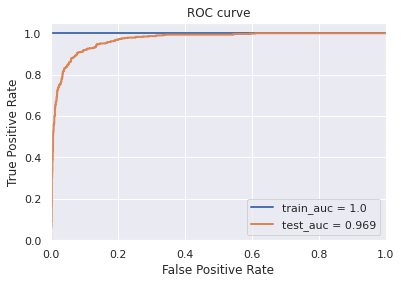



TN_result:  [688 694 684 692 694]  TN_mean:  690
FP_result:  [37 31 41 33 30]  FP_result:  34
FN_result:  [53 52 47 44 55]  FN_result:  50
TP_result:  [212 212 217 220 210]  TP_result:  214
accuracy: 0.9149797570850202
precision: 0.8629032258064516
sensitivity: 0.8106060606060606
specificity: 0.9530386740331491
MCC: 0.7793291266755875




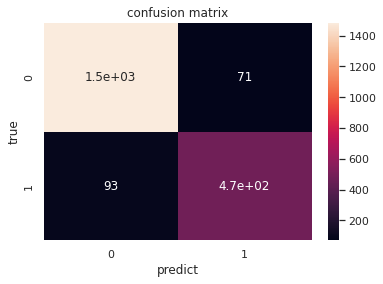

In [ ]:
rf_model = RandomForestClassifier(**best_para)
rf_model.fit(rf_train, y_train)
plt.figure()
df_rf, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(rf_train, y_train, rf_test, y_test, rf_model, 'train', 'test')
plt.show()

print("\n")
pointer(rf_model, rf_train, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

In [ ]:
rf_model = RandomForestClassifier(**best_para)
rf_model.fit(rf_train, y_train)

value = rf_model.feature_importances_
importances = pd.DataFrame(value, columns=["importance"])
feature_data = pd.DataFrame(rf_train.columns, columns=["feature"])
importance = pd.concat([feature_data, importances], axis=1)

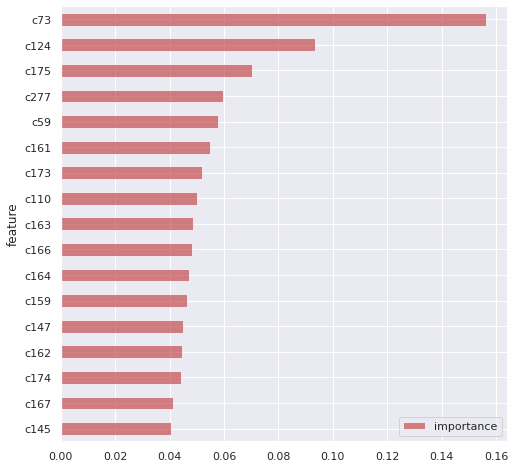

In [ ]:
importance = importance.sort_values(["importance"], ascending=True)
importance.set_index('feature', inplace=True)
importance.plot.barh(color='r', alpha=0.7, rot=0, figsize=(8, 8))
plt.show()

# load model

In [ ]:
from joblib import dump, load

In [ ]:
dump(xgb_model, "109350008_HW2")

['109350008_HW1']

In [ ]:
f = xgb_train.columns.to_list()

In [ ]:
f = pd.DataFrame(f).T

In [ ]:
f.to_csv("/content/drive/MyDrive/HW1_feature.csv", index = False)

In [ ]:
test = load("109350008_HW1")

In [ ]:
pointer(test, xgb_train, y_train)

TN_result:  [697 692 689 694 698]  TN_mean:  694
FP_result:  [28 33 36 31 26]  FP_result:  31
FN_result:  [32 38 35 33 42]  FN_result:  36
TP_result:  [233 226 229 231 223]  TP_result:  228
accuracy: 0.9322548028311426
precision: 0.8803088803088803
sensitivity: 0.8636363636363636
specificity: 0.9572413793103448
MCC: 0.8259202895231342
